<h1>  <center> Dose mimicking IMRT </center> </h1>

Please download compress rtp extension available at [compressRTP](https://github.com/PortPy-Project/CompressRTP) before running this notebook and append it to path of the current notebook as shown below

In [3]:
import sys
sys.path.append('../../CompressRTP')
sys.path.append('..')

In [5]:
import os
import portpy.photon as pp
import os
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import scipy.sparse
from compress_rtp.utils.get_sparse_only import get_sparse_only

# predicted dose back to portpy
patient_id = 'Lung_Patient_4'

# load portpy data
data = pp.DataExplorer(data_dir='../data')
data.patient_id = patient_id
# Load ct and structure set for the above patient using CT and Structures class
ct = pp.CT(data)
structs = pp.Structures(data)

beams = pp.Beams(data, load_inf_matrix_full=True)

# create rinds based upon rind definition in optimization params
protocol_name = 'Lung_2Gy_30Fx'
opt_params = data.load_config_opt_params(protocol_name=protocol_name)

# load influence matrix based upon beams and structure set
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams, is_full=True)

Creating BEV..
Loading full influence matrix..
Done


In [6]:
# sparsify the influence matrix using compressRTP extension. 
A_full = deepcopy(inf_matrix.A)
B = get_sparse_only(A_full, threshold_perc=5, compression='rmr')
inf_matrix.A = B
# load clinical criteria from the config files for which plan to be optimized
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)
# create a plan using ct, structures, beams and influence matrix. Clinical criteria is optional
my_plan = pp.Plan(ct=ct, structs=structs, beams=beams, inf_matrix=inf_matrix, clinical_criteria=clinical_criteria)

Generating sparse matrix using RMR...


In [7]:
# import the predicted dose to PortPy. Point to dose file of the benchmark plan available in PortPy
pred_dose = pp.convert_dose_rt_dicom_to_portpy(my_plan=my_plan, dose_file_name=r'\\PortPy\data\zip_files\export_clinic\rt_dose_echo_imrt.dcm')
pred_dose_1d = inf_matrix.dose_3d_to_1d(dose_3d=pred_dose)

In [8]:
# create cvxpy problem with simple ptv and oar objective.
opt = pp.Optimization(my_plan, opt_params=opt_params)
A = inf_matrix.A
x = cp.Variable(A.shape[1], pos=True)
opt.vars['x'] = x
ptv_vox = inf_matrix.get_opt_voxels_idx('PTV')
opt.obj += [(1 / len(ptv_vox)) * cp.sum_squares(A[ptv_vox, :] @ x - pred_dose_1d[ptv_vox] / my_plan.get_num_of_fractions())]
opt.obj += [0.3*(1 / len(ptv_vox)) * cp.sum_squares(A[ptv_vox, :] @ x - my_plan.get_prescription() / my_plan.get_num_of_fractions())]
# voxel weights for oar objectives
all_vox = np.arange(A.shape[0])
oar_voxels = all_vox[~np.isin(np.arange(A.shape[0]), ptv_vox)]
dO = cp.Variable(oar_voxels.shape[0], pos=True)
opt.constraints += [A[oar_voxels, :] @ x <= pred_dose_1d[oar_voxels] / my_plan.get_num_of_fractions() + dO]
opt.obj += [(1 / dO.shape[0]) * cp.sum_squares(dO)]
opt.obj += [0.0001 * (1 / dO.shape[0]) * cp.sum_squares(A[oar_voxels, :] @ x)]
[Qx, Qy, num_rows, num_cols] = opt.get_smoothness_matrix(inf_matrix.beamlets_dict)
smoothness_X_weight = 0.6
smoothness_Y_weight = 0.4
opt.obj += [(smoothness_X_weight * (1 / num_cols) * cp.sum_squares(Qx @ x) +
            smoothness_Y_weight * (1 / num_rows) * cp.sum_squares(Qy @ x))]

sol = opt.solve(solver='MOSEK', verbose=True)
# sol = opt.solve(solver='MOSEK', verbose=True)
sol = {'optimal_intensity': x.value, 'inf_matrix': inf_matrix}

Running Optimization..
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Dec 03 04:06:50 PM: Your problem has 417094 variables, 1 constraints, and 0 parameters.
(CVXPY) Dec 03 04:06:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 03 04:06:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 03 04:06:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 03 04:06:50 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Dec 03 04:06:50 PM: Reduction chain: Dcp2Cone -> CvxAttr2Con

(CVXPY) Dec 03 04:09:00 PM: 23  1.4e-07  1.5e-05  2.2e-10  1.69e+00   1.215604172e-02   1.215642644e-02   1.4e-07  85.59 
(CVXPY) Dec 03 04:09:03 PM: 24  8.0e-08  8.2e-06  8.7e-11  1.51e+00   1.018883977e-02   1.018903199e-02   8.0e-08  87.89 
(CVXPY) Dec 03 04:09:05 PM: 25  2.3e-08  8.5e-06  1.0e-11  1.40e+00   8.590795322e-03   8.590841683e-03   2.3e-08  90.14 
(CVXPY) Dec 03 04:09:08 PM: 26  5.2e-09  3.5e-05  8.7e-13  1.25e+00   8.172978594e-03   8.172988316e-03   5.2e-09  92.91 
(CVXPY) Dec 03 04:09:09 PM: Optimizer terminated. Time: 93.88   
(CVXPY) Dec 03 04:09:09 PM: 
(CVXPY) Dec 03 04:09:09 PM: 
(CVXPY) Dec 03 04:09:09 PM: Interior-point solution summary
(CVXPY) Dec 03 04:09:09 PM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) Dec 03 04:09:09 PM:   Solution status : OPTIMAL
(CVXPY) Dec 03 04:09:09 PM:   Primal.  obj: 8.1729785936e-03    nrm: 3e-03    Viol.  con: 1e-09    var: 5e-09    cones: 0e+00  
(CVXPY) Dec 03 04:09:09 PM:   Dual.    obj: 8.1729883157e-03    nrm: 1e+

In [ ]:
# Specify the location and name of the DICOM RT Dose file

dose_file_name = r'PortPy\data\zip_files\export_clinic\PredFluRMR\RD.dcm'
# Convert the DICOM dose into PortPy format
ecl_dose_3d = pp.convert_dose_rt_dicom_to_portpy(my_plan=my_plan, dose_file_name=dose_file_name)
ecl_dose_1d = inf_matrix.dose_3d_to_1d(dose_3d=ecl_dose_3d)

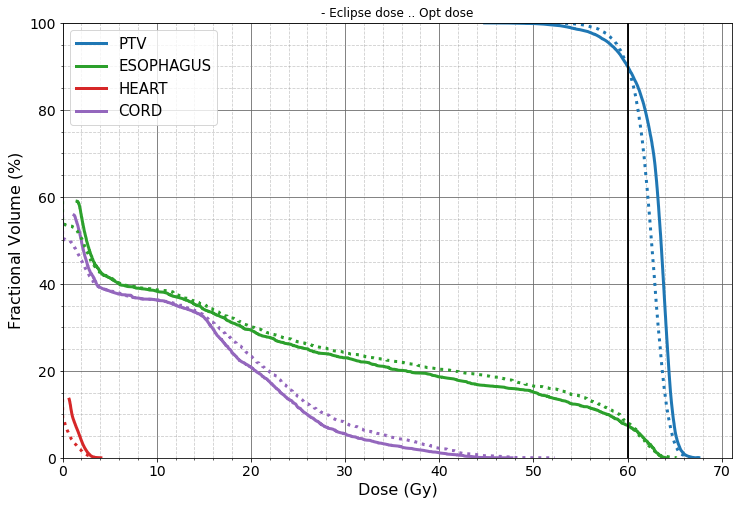

In [10]:
# visualize the dvh discrepancy between eclipse and PortPy dose
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=ecl_dose_1d, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
ax = pp.Visualization.plot_dvh(my_plan, sol=sol, struct_names=struct_names, style='dotted', ax=ax, norm_flag=True)
ax.set_title('- Eclipse dose .. Opt dose')
plt.show()

In [ ]:

# get fluence
pp.get_eclipse_fluence(my_plan=my_plan, sol=sol, path=r'C:\Temp\Lung_Patient_4', normalize_fluence=True)
# import ct and structures. Create a plan with beams used in optimization and import the fluence. 
data.get_tcia_metadata('Lung_Patient_4')

Running Optimization..
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Dec 05 09:13:04 AM: Your problem has 417094 variables, 1 constraints, and 0 parameters.
(CVXPY) Dec 05 09:13:04 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 05 09:13:04 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 05 09:13:04 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 05 09:13:04 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Dec 05 09:13:04 AM: Reduction chain: Dcp2Cone -> CvxAttr2Con

(CVXPY) Dec 05 09:15:22 AM: 23  4.6e-07  2.2e-04  1.8e-09  1.65e+00   2.944592735e-02   2.944787149e-02   4.6e-07  93.00 
(CVXPY) Dec 05 09:15:24 AM: 24  1.9e-07  1.1e-04  3.8e-10  1.71e+00   1.651155374e-02   1.651216377e-02   1.9e-07  95.41 
(CVXPY) Dec 05 09:15:27 AM: 25  5.6e-08  2.1e-05  3.7e-11  1.52e+00   1.143359382e-02   1.143373154e-02   5.6e-08  98.38 
(CVXPY) Dec 05 09:15:30 AM: 26  1.8e-08  3.5e-05  6.1e-12  1.52e+00   1.003542315e-02   1.003545983e-02   1.8e-08  101.39
(CVXPY) Dec 05 09:15:35 AM: 27  4.1e-09  1.6e-04  1.2e-13  1.14e+00   9.726230194e-03   9.726234733e-03   2.4e-09  105.83
(CVXPY) Dec 05 09:15:36 AM: Optimizer terminated. Time: 106.72  
(CVXPY) Dec 05 09:15:36 AM: 
(CVXPY) Dec 05 09:15:36 AM: 
(CVXPY) Dec 05 09:15:36 AM: Interior-point solution summary
(CVXPY) Dec 05 09:15:36 AM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) Dec 05 09:15:36 AM:   Solution status : OPTIMAL
(CVXPY) Dec 05 09:15:36 AM:   Primal.  obj: 9.7262301941e-03    nrm: 8e-03    

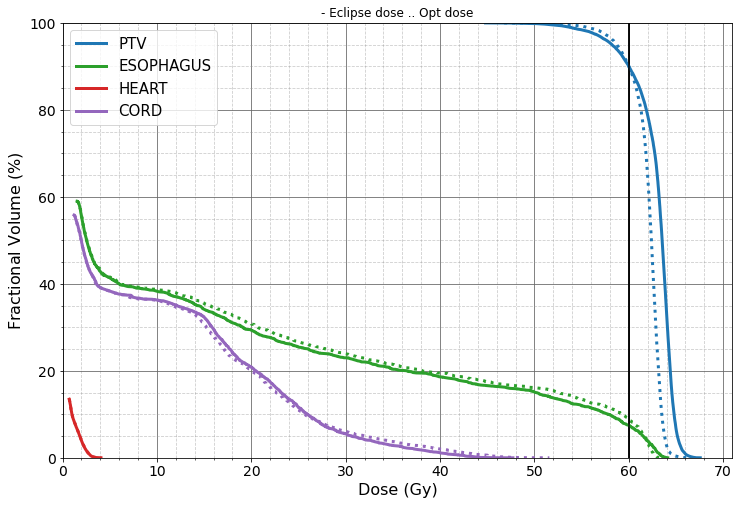

Done!
Running Optimization..
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Dec 05 09:15:39 AM: Your problem has 417094 variables, 1 constraints, and 0 parameters.
(CVXPY) Dec 05 09:15:39 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 05 09:15:39 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 05 09:15:39 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 05 09:15:39 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Dec 05 09:15:39 AM: Reduction chain: Dcp2Cone -> CvxAt

(CVXPY) Dec 05 09:17:54 AM: 23  1.2e-06  9.0e-02  1.1e-08  1.29e+00   6.813890410e-02   6.814580063e-02   1.2e-06  90.84 
(CVXPY) Dec 05 09:17:57 AM: 24  7.7e-07  5.9e-02  5.1e-09  1.58e+00   4.492182017e-02   4.492569838e-02   7.7e-07  93.25 
(CVXPY) Dec 05 09:17:59 AM: 25  5.6e-07  4.4e-02  2.8e-09  1.66e+00   3.248424109e-02   3.248671093e-02   5.6e-07  95.66 
(CVXPY) Dec 05 09:18:01 AM: 26  4.1e-07  3.2e-02  1.6e-09  1.69e+00   2.418185780e-02   2.418342002e-02   4.1e-07  97.94 
(CVXPY) Dec 05 09:18:04 AM: 27  1.9e-07  1.5e-02  4.0e-10  1.65e+00   1.460671709e-02   1.460728847e-02   1.9e-07  100.34
(CVXPY) Dec 05 09:18:06 AM: 28  7.4e-08  5.7e-03  7.4e-11  1.57e+00   1.044203550e-02   1.044221073e-02   7.4e-08  102.72
(CVXPY) Dec 05 09:18:09 AM: 29  1.8e-08  1.4e-03  5.9e-12  1.45e+00   8.791195544e-03   8.791230672e-03   1.8e-08  105.77
(CVXPY) Dec 05 09:18:13 AM: 30  3.5e-09  2.0e-04  1.9e-13  1.18e+00   8.467218843e-03   8.467223886e-03   2.8e-09  109.59
(CVXPY) Dec 05 09:18:14 

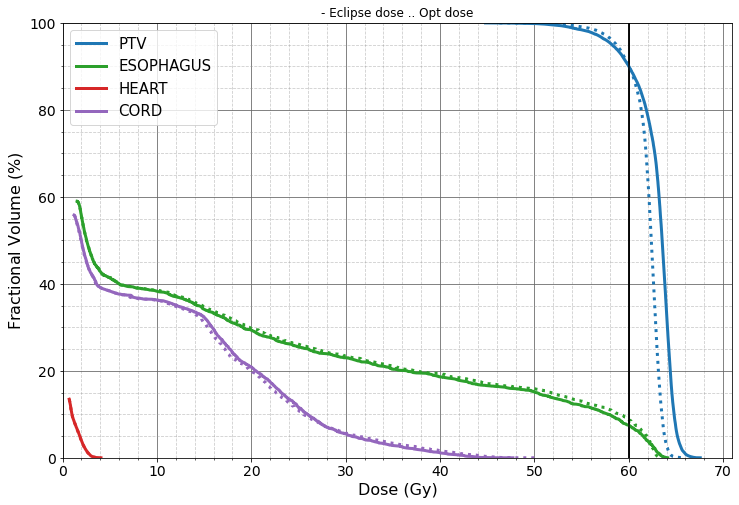

Done!
Running Optimization..
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Dec 05 09:18:17 AM: Your problem has 417094 variables, 1 constraints, and 0 parameters.
(CVXPY) Dec 05 09:18:17 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 05 09:18:17 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 05 09:18:17 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 05 09:18:17 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Dec 05 09:18:17 AM: Reduction chain: Dcp2Cone -> CvxAt

(CVXPY) Dec 05 09:20:30 AM: 23  8.2e-07  4.8e-04  6.0e-09  1.56e+00   5.657887435e-02   5.658354624e-02   8.2e-07  89.81 
(CVXPY) Dec 05 09:20:33 AM: 24  6.1e-07  2.4e-03  3.1e-09  2.35e+00   2.801813837e-02   2.802064882e-02   6.1e-07  92.20 
(CVXPY) Dec 05 09:20:35 AM: 25  2.9e-07  1.1e-03  9.0e-10  1.33e+00   2.282195866e-02   2.282303163e-02   2.9e-07  94.62 
(CVXPY) Dec 05 09:20:37 AM: 26  1.7e-07  6.6e-04  2.9e-10  2.18e+00   1.171651123e-02   1.171692549e-02   1.7e-07  97.06 
(CVXPY) Dec 05 09:20:40 AM: 27  6.2e-08  2.5e-04  5.9e-11  1.28e+00   1.049581521e-02   1.049595889e-02   6.2e-08  99.53 
(CVXPY) Dec 05 09:20:42 AM: 28  2.3e-08  1.7e-04  1.1e-11  1.58e+00   8.812256313e-03   8.812298758e-03   2.3e-08  101.95
(CVXPY) Dec 05 09:20:47 AM: 29  3.1e-09  3.0e-04  1.9e-13  1.15e+00   8.510547615e-03   8.510553238e-03   3.1e-09  106.33
(CVXPY) Dec 05 09:20:48 AM: Optimizer terminated. Time: 107.22  
(CVXPY) Dec 05 09:20:48 AM: 
(CVXPY) Dec 05 09:20:48 AM: 
(CVXPY) Dec 05 09:20:48

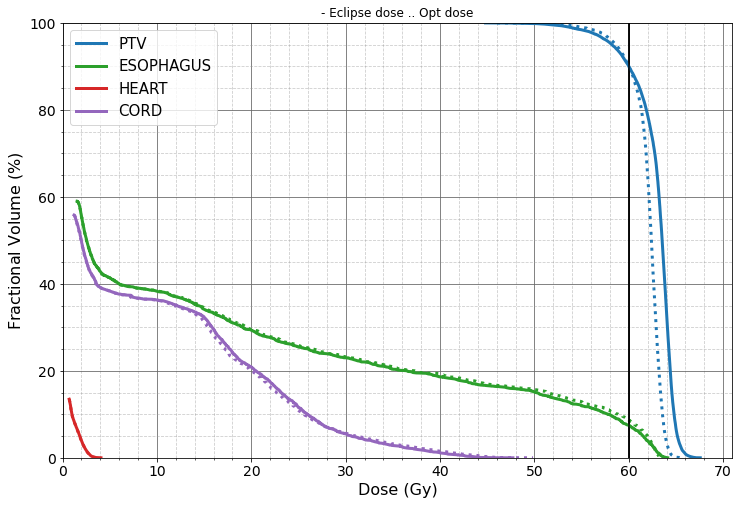

Done!


In [9]:


# Correct using ecl dose
# Dose correction using full matrix
dose_opt_1d = inf_matrix.A @ (sol['optimal_intensity']*my_plan.get_num_of_fractions())
norm_factor_opt = pp.Evaluation.get_dose(sol, dose_1d=dose_opt_1d, struct='PTV', volume_per=90) / my_plan.get_prescription()
dose_opt_1d_norm = dose_opt_1d / norm_factor_opt

norm_factor_ecl = pp.Evaluation.get_dose(sol, dose_1d=ecl_dose_1d, struct='PTV', volume_per=90) / my_plan.get_prescription()
ecl_dose_1d_norm = ecl_dose_1d / norm_factor_ecl

delta = (ecl_dose_1d_norm - dose_opt_1d_norm)/my_plan.get_num_of_fractions()
old_delta = delta
num_corr = 2 # Users can set number of corrections
sol_corrs = []
dose_corrs = []
for i in range(num_corr):
    opt = pp.Optimization(my_plan, opt_params=opt_params)

    # x = opt.vars['x']
    A = inf_matrix.A
    x = cp.Variable(A.shape[1], pos=True)
    opt.vars['x'] = x
    ptv_vox = inf_matrix.get_opt_voxels_idx('PTV')
    opt.obj += [(1 / len(ptv_vox)) * cp.sum_squares(A[ptv_vox, :] @ x + delta[ptv_vox] - pred_dose_1d[ptv_vox] / my_plan.get_num_of_fractions())]
    opt.obj += [0.3 * (1 / len(ptv_vox)) * cp.sum_squares(A[ptv_vox, :] @ x + delta[ptv_vox] - my_plan.get_prescription() / my_plan.get_num_of_fractions())]
    # voxel weights for oar objectives
    all_vox = np.arange(A.shape[0])
    oar_voxels = all_vox[~np.isin(np.arange(A.shape[0]), ptv_vox)]
    dO = cp.Variable(oar_voxels.shape[0], pos=True)
    opt.constraints += [A[oar_voxels, :] @ x + delta[oar_voxels] <= pred_dose_1d[oar_voxels] / my_plan.get_num_of_fractions() + dO]
    opt.obj += [(1 / dO.shape[0]) * cp.sum_squares(dO)]
    opt.obj += [0.0001 * (1 / dO.shape[0]) * cp.sum_squares(A[oar_voxels, :] @ x + delta[oar_voxels])]
    [Qx, Qy, num_rows, num_cols] = opt.get_smoothness_matrix(inf_matrix.beamlets_dict)
    smoothness_X_weight = 0.6
    smoothness_Y_weight = 0.4
    opt.obj += [3*(smoothness_X_weight * (1 / num_cols) * cp.sum_squares(Qx @ x) +
                 smoothness_Y_weight * (1 / num_rows) * cp.sum_squares(Qy @ x))]

    sol_corr = opt.solve(solver='MOSEK', verbose=True)
    # sol = opt.solve(solver='MOSEK', verbose=True)
    sol_corr = {'optimal_intensity': x.value, 'inf_matrix': inf_matrix}
    sol_corrs += [sol_corr]
    dose_sparse_corr_1d = (inf_matrix.A @ sol_corr['optimal_intensity'] + delta) * my_plan.get_num_of_fractions()
    dose_corrs.append(dose_sparse_corr_1d)
    # dose_full_corr_1d = inf_matrix_full.A @ (sol_corr['optimal_intensity'] * my_plan.get_num_of_fractions())
    # recalculate delta
    norm_volume = 90
    norm_struct = 'PTV'
    pres = my_plan.get_prescription()

    norm_factor_sparse = pp.Evaluation.get_dose(sol, dose_1d=dose_sparse_corr_1d, struct=norm_struct, volume_per=norm_volume) / pres
    dose_sparse_corr_1d_norm = dose_sparse_corr_1d / norm_factor_sparse

    # norm_factor_ecl = pp.Evaluation.get_dose(sol, dose_1d=ecl_dose_1d_norm, struct=norm_struct, volume_per=norm_volume) / pres
    # ecl_dose_1d_norm = ecl_dose_1d / norm_factor_full

    delta = (ecl_dose_1d_norm - dose_sparse_corr_1d_norm) / my_plan.get_num_of_fractions()
    # Visualize DVH in correction step
    struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
    fig, ax = plt.subplots(figsize=(12, 8))
    ax = pp.Visualization.plot_dvh(my_plan, dose_1d=dose_sparse_corr_1d, struct_names=struct_names, style='dotted', ax=ax, norm_flag=True)
    ax = pp.Visualization.plot_dvh(my_plan, dose_1d=ecl_dose_1d, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
    ax.set_title('- Eclipse dose .. Opt dose')
    plt.show()
    print('Done!')
    delta = old_delta + delta
    old_delta = delta

In [ ]:
# generate fluence and import it to eclipse and Run dose calculation. 
pp.get_eclipse_fluence(my_plan=my_plan, sol=sol, path=r'C:\Temp\Lung_Patient_4', normalize_fluence=True)

Visualize the plan in eclipse by comparing predicted plan with Optimized plan

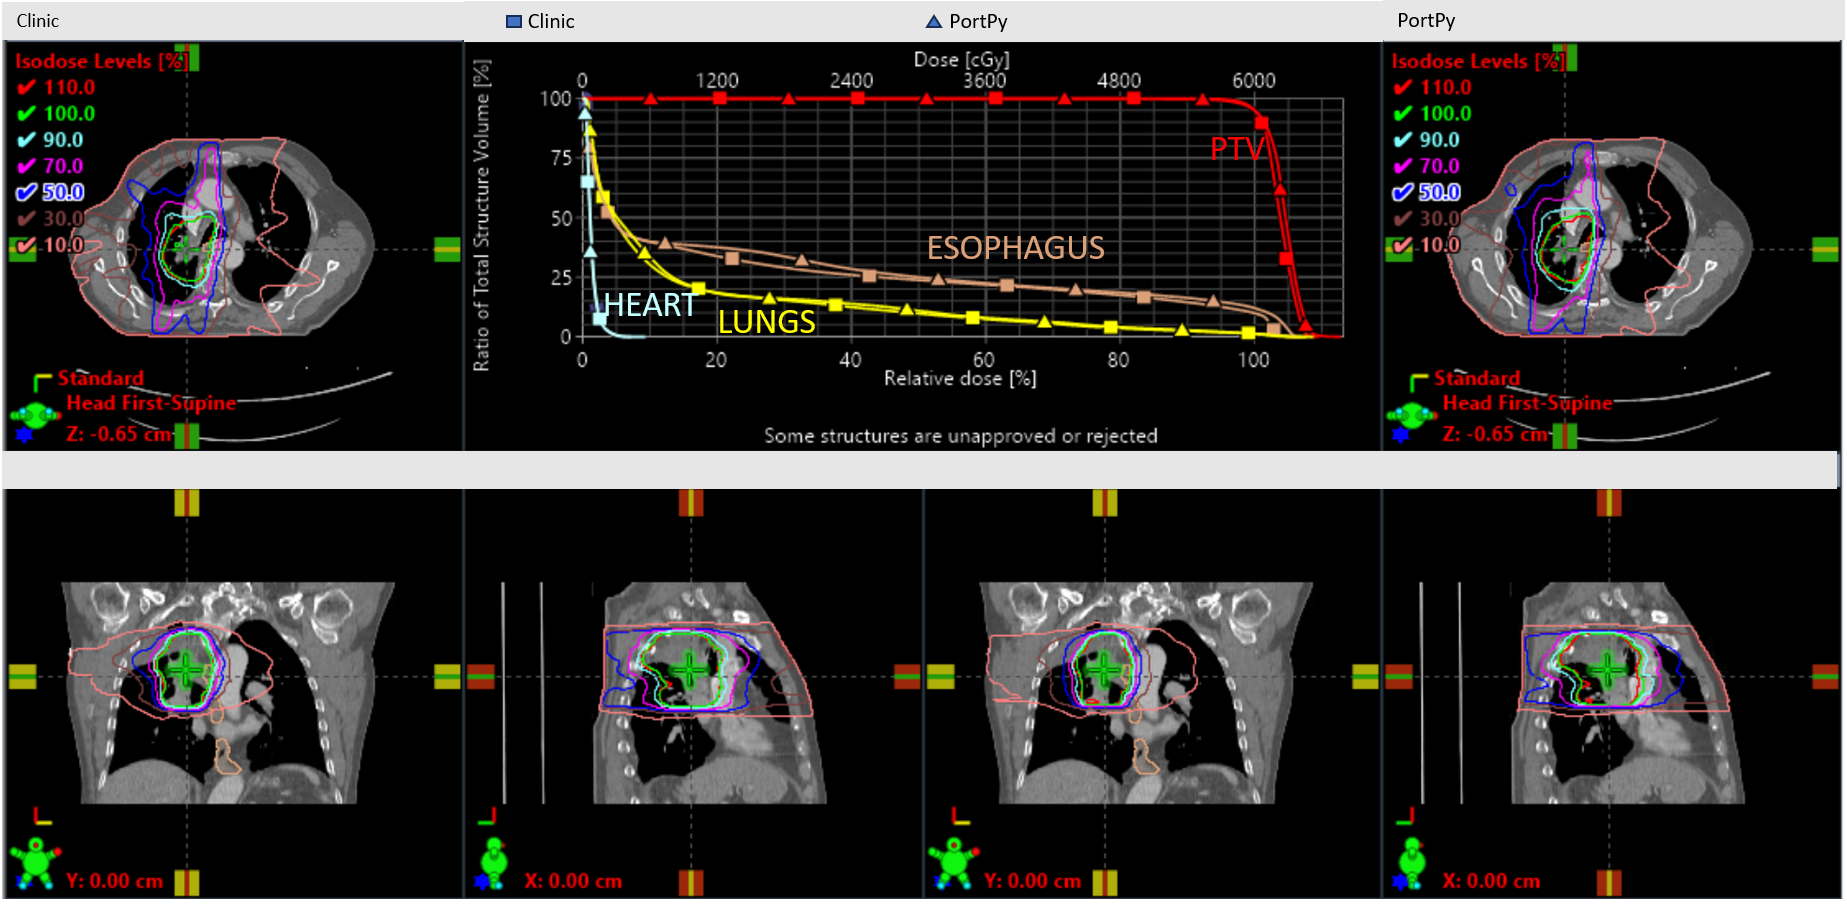